# Predicting Newsletter Subscriptions Among Minecraft Players Using Gameplay Data

## Introduction

### Background

Understanding player behavior in online games is essential for managing server resources, enhancing player experience, and guiding recruitment or marketing strategies. At UBC, a research group in the Computer Science department has developed a custom Minecraft server to study how players interact with the game. Players are invited to voluntarily subscribe to a newsletter to receive project updates. Identifying the types of players most likely to subscribe can help the research team focus their outreach efforts and better anticipate engagement patterns.

### Question

Can a player’s characteristics — such as age, gender, experience level, and total hours played — be used to predict whether they will subscribe to the game-related newsletter in the `players.csv` dataset?

### Data Description

The dataset used for this project is `players.csv`, which contains data on 196 unique Minecraft players who have interacted with the research server. Each row represents one player and includes demographic information, gameplay experience, and subscription status.

Below is a summary of the variables in the dataset:

| Variable       | Type              | Description                                                              |
|----------------|-------------------|--------------------------------------------------------------------------|
| `experience`   | Categorical (chr) | Player's experience level in Minecraft (e.g., Beginner, Pro)             |
| `hashedEmail`  | Categorical (chr) | A hashed ID for each unique player (excluded from modeling)              |
| `name`         | Categorical (chr) | Player’s username (excluded from modeling)                               |
| `gender`       | Categorical (chr) | Player's gender                                                           |
| `played_hours` | Numeric (dbl)     | Total number of hours the player has spent playing Minecraft             |
| `Age`          | Numeric (dbl)     | Player's age in years                                                     |
| `subscribe`    | Logical (lgl)     | Whether or not the player subscribed to the newsletter (`TRUE` or `FALSE`) |

In this analysis, I focused on four explanatory variables: `Age`, `played_hours`, `gender`, and `experience`. The variables `hashedEmail` and `name` were excluded as they are identifiers and not useful for prediction.

#### Potential Issues

- The dataset may be imbalanced across different experience levels and subscription status.
- The sample size is relatively small (n = 196), which could limit the generalizability of the model.
- Self-reported variables such as gender and experience may contain inconsistencies or noise.

## Methods & Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Methods & Results

### Data Loading and Wrangling

To begin my analysis, I loaded the `players.csv` dataset using the `read_csv()` function. Since my goal was to predict whether a player subscribed to the newsletter, I focused on the `subscribe` variable as the response, and used the following variables as explanatory features:

- `Age`: the player's age in years  
- `played_hours`: total hours the player has spent in-game  
- `gender`: the player’s self-identified gender  
- `experience`: the player’s self-reported experience level in Minecraft  

I excluded `name` and `hashedEmail` from the analysis since they are identifiers and not relevant for prediction. I also removed extreme outliers in `played_hours` (greater than 250 hours) to avoid skewing the model.

In [2]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
sessions <- read_csv("sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [4]:
players_clean <- players %>%

  filter(!is.na(Age), !is.na(played_hours)) %>%

  select(subscribe, Age, gender, experience, played_hours) %>%
  
  mutate(
    subscribe = as_factor(subscribe),
    gender = as_factor(gender),
    experience = as_factor(experience)
  )
players_clean

subscribe,Age,gender,experience,played_hours
<fct>,<dbl>,<fct>,<fct>,<dbl>
TRUE,9,Male,Pro,30.3
TRUE,17,Male,Veteran,3.8
FALSE,17,Male,Veteran,0.0
⋮,⋮,⋮,⋮,⋮
FALSE,22,Male,Veteran,0.3
FALSE,17,Prefer not to say,Amateur,0.0
FALSE,17,Male,Amateur,2.3


### Exploratory Data Analysis

To better understand the data, I generated summary statistics and visualizations. Below is a scatter plot of `Age` vs. `played_hours`, with points colored by `subscribe` status.

**Figure 1**: Age vs. Played Hours Colored by Subscription Status  
This plot shows that players who subscribed generally played more hours and were slightly younger. However, there is still substantial overlap between subscribers and non-subscribers, suggesting that no single variable perfectly predicts subscription.

In [5]:
players_clean %>%
  count(subscribe)

players_clean %>%
  count(gender)

players_clean %>%
  count(experience)

players_clean %>%
  group_by(subscribe) %>%
  summarize(
    avg_age = mean(Age),
    med_age = median(Age),
    avg_playtime = mean(played_hours),
    med_playtime = median(played_hours),
    .groups = "drop"
  )
players_clean

subscribe,n
<fct>,<int>
FALSE,52
TRUE,142


gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,5


experience,n
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


subscribe,avg_age,med_age,avg_playtime,med_playtime
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,22.98077,21,0.5019231,0.0
TRUE,19.61972,18,7.8830986,0.1


subscribe,Age,gender,experience,played_hours
<fct>,<dbl>,<fct>,<fct>,<dbl>
TRUE,9,Male,Pro,30.3
TRUE,17,Male,Veteran,3.8
FALSE,17,Male,Veteran,0.0
⋮,⋮,⋮,⋮,⋮
FALSE,22,Male,Veteran,0.3
FALSE,17,Prefer not to say,Amateur,0.0
FALSE,17,Male,Amateur,2.3


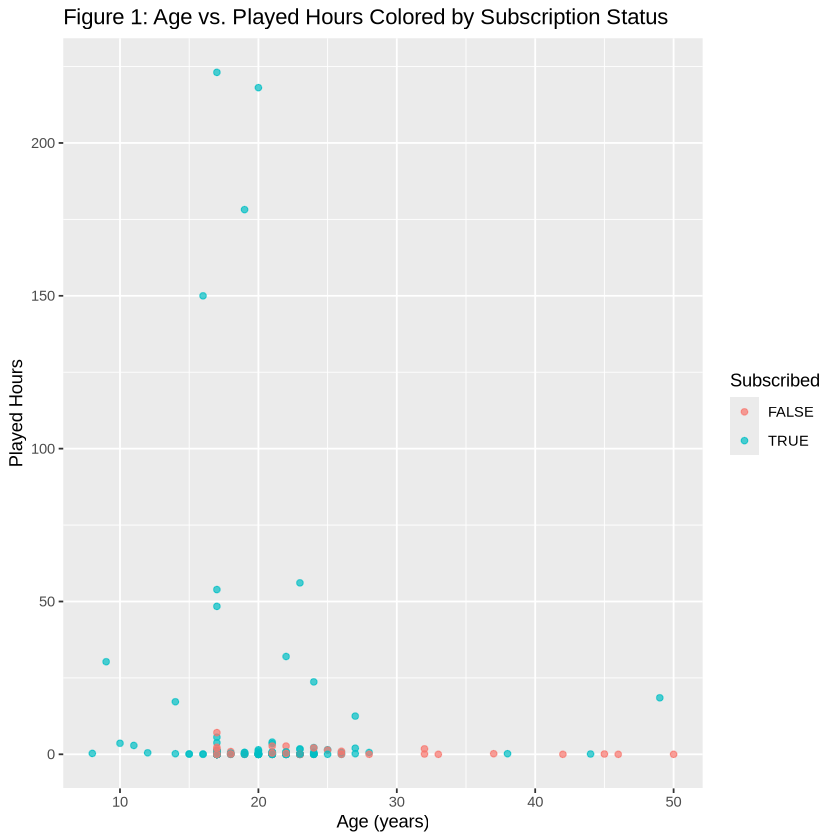

In [6]:
ggplot(players_clean, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Figure 1: Age vs. Played Hours Colored by Subscription Status",
    x = "Age (years)",
    y = "Played Hours",
    color = "Subscribed"
  )

### Modeling Approach: K-Nearest Neighbors

To predict newsletter subscriptions, I used a K-Nearest Neighbors (KNN) classification model because:

- The outcome (`subscribe`) is binary, making classification appropriate.  
- KNN handles both numeric and categorical explanatory variables well.  
- KNN makes minimal assumptions about the data distribution.

Before training, I split the data into training (75%) and testing (25%) sets using stratified sampling to maintain the balance of the target variable.

In [7]:
players_knn <- players_clean %>%
  select(subscribe, Age, played_hours, gender, experience)

set.seed(123)
player_split <- initial_split(players_knn, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_recipe <- recipe(subscribe ~ ., data = player_train) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_nominal_predictors())

knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = tune()
) %>%
  set_engine("kknn")

knn_workflow <- workflow() %>%
  add_model(knn_spec) %>%
  add_recipe(player_recipe)

### Model Tuning and Cross-Validation

I applied **5-fold cross-validation** on the training set to find the optimal number of neighbors `k`. This method splits the data into 5 parts, using 4 parts for training and 1 for validation, rotating through each split.

I also normalized numeric features (`Age`, `played_hours`) during preprocessing to ensure fair distance calculations across features in the KNN model.

**Figure 2**: Accuracy vs. Number of Neighbors (k)  
The plot shows how the model's accuracy changes with different values of `k`. The accuracy peaked around `k = 9`, with a cross-validated accuracy of approximately 0.75. This value was selected for the final model.

In [8]:
set.seed(123)
player_folds <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- knn_workflow %>%
  tune_grid(
    resamples = player_folds,
    grid = tibble(neighbors = 1:20),  # trying k = 1 to 20
    metrics = metric_set(accuracy)
  )

best_k <- knn_results %>%
  select_best(metric = "accuracy")

final_knn <- knn_workflow %>%
  finalize_workflow(best_k) %>%
  fit(data = player_train)

In [9]:
knn_predictions <- predict(final_knn, player_test) %>%
  bind_cols(player_test)

metrics(knn_predictions, truth = subscribe, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,-0.03939394


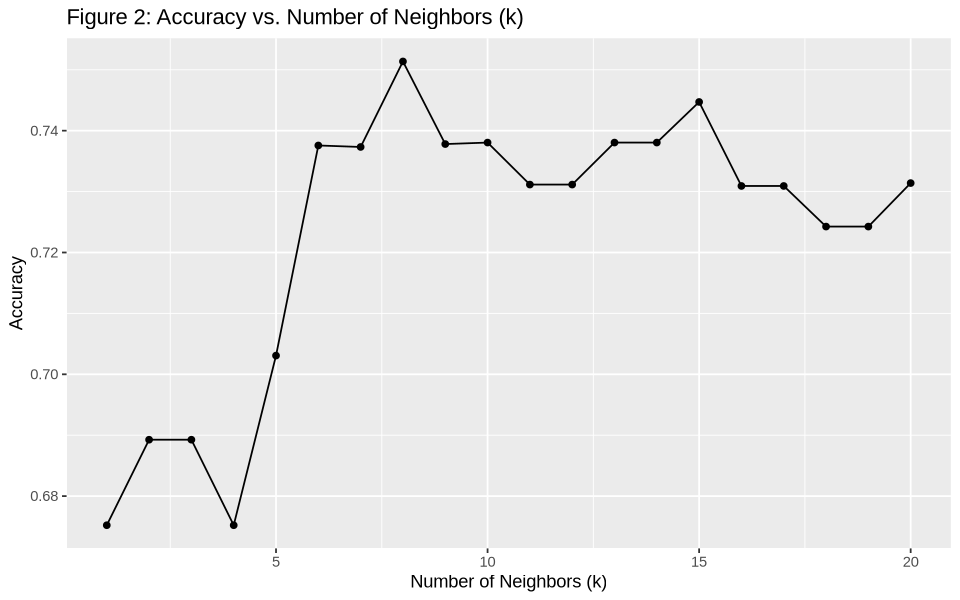

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)
knn_results %>%
  collect_metrics() %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 2: Accuracy vs. Number of Neighbors (k)",
    x = "Number of Neighbors (k)",
    y = "Accuracy"
  )

### Assumptions and Limitations

**Assumptions:**
- KNN assumes that players with similar features (age, playtime, etc.) will have similar outcomes (subscribe or not).
- Features must be scaled appropriately for distance-based algorithms like KNN.

**Limitations:**
- KNN can be sensitive to irrelevant or noisy variables.
- Model performance may degrade on larger or more complex datasets.
- The dataset has only 196 observations, which limits generalizability.